In [13]:
import jax.numpy as jnp
import jax
import os
import pickle
import math

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

os.chdir('/home/zongchen/chard/')

import matplotlib.pyplot as plt

from kwgflows.rkhs.kernels import *
import ot
from kwgflows.divergences.mmd import *
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 20
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')
plt.tight_layout()

plt.rc('font', size=20)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=18, frameon=False)
plt.rc('xtick', labelsize=14, direction='in')
plt.rc('ytick', labelsize=14, direction='in')
plt.rc('figure', figsize=(6, 4))


<Figure size 600x400 with 0 Axes>

In [14]:
kernel_list = ['Gaussian', 'Laplace', 'IMQ']
chard_trajectory = {e: None for e in kernel_list}

for ker in kernel_list:
    chard_dir = f'/home/zongchen/chard/results_rebuttal/ThreeRing_dataset/{ker}_kernel/chard_flow/'
    chard_hyper = ['lmbda_0.01_', 
                'step_num_10000_',
                'source_particle_num_300_',
                'nystrom_0',
                'inject_noise_scale_0.0_',
                'opt_sgd_']

    for file in os.listdir(chard_dir):
        if all(hyper in file for hyper in chard_hyper):
            chard_trajectory[ker] = jnp.load(chard_dir + file + '/Ys.npy')
            chard_config = pickle.load(open(chard_dir + file + '/configs', 'rb'))
            
            if chard_trajectory[ker] is None:
                raise ValueError('No chard trajectory found')



In [15]:
import argparse

# Define your dictionary
my_dict = chard_config

# Create the ArgumentParser object
parser = argparse.ArgumentParser(description='Convert dictionary to parser arguments')

# Add arguments to the parser based on the dictionary
for key, value in my_dict.items():
    # Determine the type of the value for proper handling
    if isinstance(value, int):
        parser.add_argument(f'--{key}', type=int, default=value, help=f'{key} (default: {value})')
    else:
        parser.add_argument(f'--{key}', type=str, default=value, help=f'{key} (default: "{value}")')

# Parse command line arguments (this line is for demonstration and typically uses sys.argv)
args = parser.parse_args([])  # Empty list simulates no command-line arguments




In [16]:
args

Namespace(seed=40, dataset='ThreeRing', flow='chard', kernel='IMQ', spectral='tikhonov', lmbda=0.01, step_size=0.001, nystrom=0, save_path='./results_rebuttal/ThreeRing_dataset/IMQ_kernel/chard_flow/__lmbda_0.01__step_size_0.001__bandwidth_0.5__step_num_10000__source_particle_num_300__inject_noise_scale_0.0__nystrom_0__logccv_1.0__opt_sgd__seed_40', bandwidth=0.5, step_num=10000, source_particle_num=300, target_particle_num=300, diffusion_noise_scale=1.0, inject_noise_scale=0.0, logccv=1.0, opt='sgd')

In [17]:

def compute_wasserstein_distance_numpy(X, Y):
    a, b = jnp.ones((X.shape[0], )) / X.shape[0], jnp.ones((Y.shape[0], )) / Y.shape[0]
    M = ot.dist(X, Y, 'euclidean')
    W = ot.emd(a, b, M)
    Wd = (W * M).sum()
    return Wd

def compute_wasserstein_distance_trajectory(flow_1, flow_2, eval_freq):
    assert flow_1.shape[0] == flow_2.shape[0]
    T = flow_1.shape[0]
    wasserstein_distance = []
    for i in range(0, T, eval_freq):
        wasserstein_distance.append(compute_wasserstein_distance_numpy(flow_1[i, :], flow_2[i, :]))
    wasserstein_distance = jnp.array(wasserstein_distance)
    return wasserstein_distance

def compute_all_distance_trajectory(config, trajectory, target, kernel):
    mmd_divergence = mmd_fixed_target(args, kernel, None)
    mmd_divergence.pre_compute(target)
    mmd_distance = jax.vmap(mmd_divergence)(trajectory)

    chard_divergence = chard_fixed_target(args, kernel, None)
    chard_divergence.pre_compute(target)
    chard_distance = jax.vmap(chard_divergence)(trajectory)

    T = trajectory.shape[0]
    wass_distance = compute_wasserstein_distance_trajectory(trajectory, jnp.repeat(target[None, :], T, axis=0), eval_freq=1)
    return mmd_distance, chard_distance, wass_distance

In [18]:
def generate_three_ring_and_gaussian(Nx, Ny):
    rng_key = jax.random.PRNGKey(40)
    r, _delta = 0.3, 0.5
    
    X = jnp.c_[r * jnp.cos(jnp.linspace(0, 2 * jnp.pi, Nx + 1)), r * jnp.sin(jnp.linspace(0, 2 * jnp.pi, Nx + 1))][:-1]  # noqa
    for i in [1, 2]:
        X = jnp.r_[X, X[:Nx, :]-i*jnp.array([0, (2 + _delta) * r])]

    rng_key, _ = jax.random.split(rng_key)
    Y = jax.random.normal(rng_key, (Ny, 2)) / 100 - jnp.array([0, r])
    return X, Y

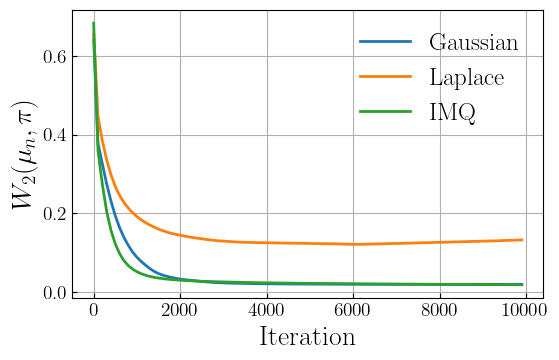

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

for i, (ker, trajectory) in enumerate(chard_trajectory.items()):
    T = trajectory.shape[0]
    x_ticks = jnp.arange(0, 100* T, 100)

    particle_num = trajectory.shape[1]

    target, _ = generate_three_ring_and_gaussian(int(particle_num/3), particle_num)
    kernel = gaussian_kernel(chard_config['bandwidth'])
    mmd, chard, wass = compute_all_distance_trajectory(chard_config, trajectory, target, kernel)
    axs.plot(x_ticks, wass, label=f'{ker}')

axs.legend(ncol=1, loc='upper right')
axs.set_xlabel('Iteration')
axs.set_ylabel(r'$W_2(\mu_n, \pi)$')
plt.tight_layout()
plt.savefig('./figures/kernel.pdf')
plt.show()